In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import glob
import re
import configparser
%matplotlib notebook

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# plt.style.use('ggplot')
# plt.rcParams['image.cmap'] = 'gray'

In [47]:
conf_path = './../conf.ini'
conf = configparser.ConfigParser()
conf.read(os.path.abspath(conf_path))

dir_saved_models = conf['PATHS']['saved_models']
dir_latex_figures = os.path.abspath('./latex/figures/')

cnn_name_mapping = dict(conf['CNN_NAME_MAPPING'])

In [48]:
# helping functions for extract paths

# prepend path to dict with paths
def prepend_path(d1, pre_path):
    def f(path):
        return os.path.join(pre_path, path)
        
    return {k: f(v) for k, v in d1.items()}

# append path to dict with paths
def append_path(d1, app_path):
    def f(path):
        return os.path.join(path, app_path)
        
    return {k: f(v) for k, v in d1.items()}

# find last checkpoint in directory with an experinment
def find_last_checkpoint(d1):
    d_new = {}
    for name, path in d1.items():
        li = glob.glob(path + '/checkpoint*')
        
        nums = []
        for el in li:
            nums.append(int(el.split('point_')[1].split('.tar')[0]))
        nums = sorted(nums)
        
        d_new[name] = os.path.join(path, 'checkpoint_' + str(nums[-1]) + '.tar')
    return d_new

# get specific checkpoint in directory with an experinment
def choose_specific_checkpoint(d1, nof_checkpoint):
    d_new = {}
    for name, path in d1.items():
        file = os.path.join(path, 'checkpoint_' + str(nof_checkpoint) + '.tar')
        assert os.path.exists(file), '%s: %s' %(name, file)
        d_new[name] = file
    return d_new

In [49]:
# freiburg paths
tmp = prepend_path(cnn_name_mapping, 'vol2')
tmp = prepend_path(tmp, dir_saved_models)
tmp = append_path(tmp, 'experiment_1')

freiburg_last_checkpoint = find_last_checkpoint(tmp)
freiburg_standard_checkpoint = choose_specific_checkpoint(tmp, 10)

In [50]:
# kitti 2015 paths
tmp = prepend_path(cnn_name_mapping, 'vol2')
tmp = prepend_path(tmp, dir_saved_models)
tmp = append_path(tmp, 'experiment_2')

kitti_2015_last_checkpoint = find_last_checkpoint(tmp)
kitti_2015_standard_checkpoint = choose_specific_checkpoint(tmp, 200)

In [51]:
# kitti 2012 paths
tmp = prepend_path(cnn_name_mapping, 'vol2')
tmp = prepend_path(tmp, dir_saved_models)
tmp = append_path(tmp, 'experiment_3')

kitti_2012_last_checkpoint = find_last_checkpoint(tmp)
kitti_2012_standard_checkpoint = choose_specific_checkpoint(tmp, 75)

In [52]:
labeling = {
    'one_res_small'          : 'OneRes (S)',
    'one_res_big'            : 'OneRes (B)',
    'mres_2d_small'          : 'MRes2d (S)',
    'mres_2d_big'            : 'MRes2d (B)',
    'mres_3d_small'          : 'MRes3d (S)',
    'mres_3d_big'            : 'MRes3d (B)',
    'mres_2d_3d_small'       : 'MRes2d3d (S)',
    'mres_2d_3d_big'         : 'MRes2d3d (B)',
    'scalable_net'           : 'MSNet',
    'scalable_net_free_2d'   : 'MSNet Free2d',
    'scalable_net_free_3d'   : 'MSNet Free3d',
    'scalable_net_free_2d_3d': 'MSNet Free2d3d'
    }

coloring = {
    'one_res_small'          : 'b',
    'one_res_big'            : 'b',
    'mres_2d_small'          : 'g',
    'mres_2d_big'            : 'g',
    'mres_3d_small'          : 'y',
    'mres_3d_big'            : 'y',
    'mres_2d_3d_small'       : 'c',
    'mres_2d_3d_big'         : 'c',
    'scalable_net'           : 'r',
    'scalable_net_free_2d'   : 'b',
    'scalable_net_free_3d'   : 'y',
    'scalable_net_free_2d_3d': 'c'
}

<IPython.core.display.Javascript object>


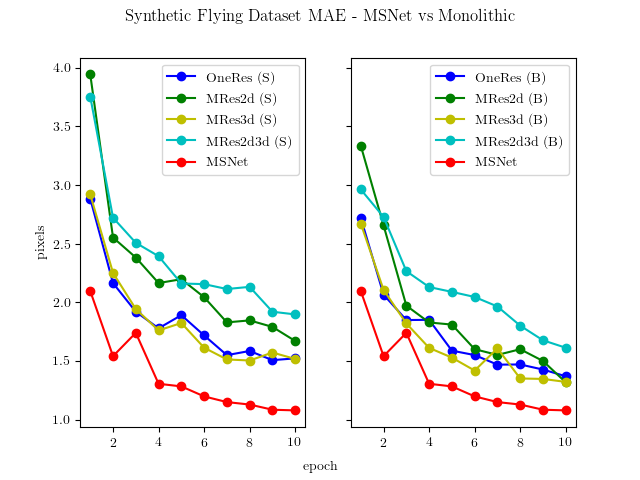

In [70]:
cnn_to_plot = ['one_res_small', 
                    'one_res_big', 
                    'mres_2d_small', 
                    'mres_2d_big',
                    'mres_3d_small', 
                    'mres_3d_big', 
                    'mres_2d_3d_small', 
                    'mres_2d_3d_big',
                    'scalable_net']
fig_name = 'freiburg_monolithic_mae.pdf'


# figure 1
fig, ax = plt.subplots(1, 2, sharey='row')

for i, cnn_name in enumerate(freiburg_standard_checkpoint.keys()):
    if cnn_name in cnn_to_plot:
    
        # load stats
        stats = torch.load(freiburg_standard_checkpoint[cnn_name])['stats']

        # load test set statistics
        if cnn_name in ['one_res_small', 'one_res_big', 'mres_2d_small', 'mres_2d_big']:
            lis = stats["test_full"]["mae"]
        elif cnn_name in ['mres_3d_small', 'mres_3d_big', 'mres_2d_3d_small', 'mres_2d_3d_big']:
            lis = stats["test_full"]["mae"]['_4']
        elif cnn_name in ['scalable_net']:
            lis = stats["test_full"]["mae"]['0_after']

        # plot line
        y = [np.mean(lis[i]) for i in range(len(lis)) ]
        x = np.arange(1, len(y) + 1)
        if cnn_name.split('_')[-1] == 'small':
            ax[0].plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])
        elif cnn_name.split('_')[-1] == 'big':
            ax[1].plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])
        else:
            ax[0].plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])
            ax[1].plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])

fig.suptitle("Synthetic Flying Dataset MAE - MSNet vs Monolithic")
ax[0].set_ylabel("pixels")
fig.text(0.5, 0.02, 'epoch', ha='center')
ax[0].legend()
ax[1].legend()
fig.savefig(os.path.join(dir_latex_figures, fig_name), bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


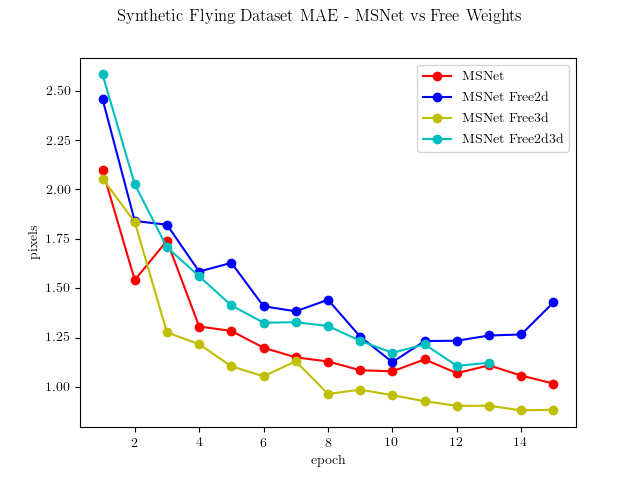

In [72]:
cnn_to_plot = ['scalable_net', 
               'scalable_net_free_2d', 
               'scalable_net_free_3d',
               'scalable_net_free_2d_3d']
fig_name = 'freiburg_scalables_mae.pdf'


# figure 1
fig, ax = plt.subplots(1, 1)

for i, cnn_name in enumerate(freiburg_last_checkpoint.keys()):
    if cnn_name in cnn_to_plot:
    
        # load stats
        stats = torch.load(freiburg_last_checkpoint[cnn_name])['stats']

        # load test set statistics
        lis = stats["test_full"]["mae"]['0_after']

        # plot line
        y = [np.mean(lis[i]) for i in range(len(lis)) ]
        x = np.arange(1, len(y) + 1)
        ax.plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])

fig.suptitle("Synthetic Flying Dataset MAE - MSNet vs Free Weights")
ax.set_ylabel("pixels")
ax.set_xlabel("epoch")
ax.legend()
fig.savefig(os.path.join(dir_latex_figures, fig_name), bbox_inches='tight')
plt.show()

In [75]:
kitti_2015_last_checkpoint

{'one_res_small': '/home/givaisile/stereo_vision/saved_models/vol2/simple_net/experiment_2/checkpoint_200.tar',
 'one_res_big': '/home/givaisile/stereo_vision/saved_models/vol2/simple_net_more/experiment_2/checkpoint_200.tar',
 'mres_2d_small': '/home/givaisile/stereo_vision/saved_models/vol2/multires_2d_less/experiment_2/checkpoint_200.tar',
 'mres_2d_big': '/home/givaisile/stereo_vision/saved_models/vol2/multires_2d/experiment_2/checkpoint_200.tar',
 'mres_3d_small': '/home/givaisile/stereo_vision/saved_models/vol2/multires_3d_less/experiment_2/checkpoint_200.tar',
 'mres_3d_big': '/home/givaisile/stereo_vision/saved_models/vol2/multires_3d/experiment_2/checkpoint_200.tar',
 'mres_2d_3d_small': '/home/givaisile/stereo_vision/saved_models/vol2/multires_2d_3d_less/experiment_2/checkpoint_200.tar',
 'mres_2d_3d_big': '/home/givaisile/stereo_vision/saved_models/vol2/multires_2d_3d/experiment_2/checkpoint_200.tar',
 'scalable_net': '/home/givaisile/stereo_vision/saved_models/vol2/merging_

<IPython.core.display.Javascript object>


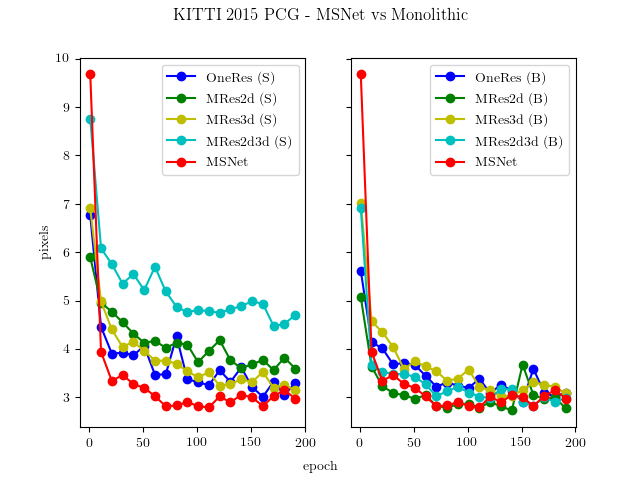

In [96]:
cnn_to_plot = ['one_res_small', 
                    'one_res_big', 
                    'mres_2d_small', 
                    'mres_2d_big',
                    'mres_3d_small', 
                    'mres_3d_big', 
                    'mres_2d_3d_small', 
                    'mres_2d_3d_big',
                    'scalable_net']
fig_name = 'kitti_2015_monolithic_pcg.pdf'


# figure 1
fig, ax = plt.subplots(1, 2, sharey='row')

for i, cnn_name in enumerate(kitti_2015_last_checkpoint.keys()):
    if cnn_name in cnn_to_plot:
    
        # load stats
        stats = torch.load(kitti_2015_last_checkpoint[cnn_name])['stats']

        # load test set statistics
        if cnn_name in ['one_res_small', 'one_res_big', 'mres_2d_small', 'mres_2d_big']:
            lis = stats["val_full"]["pcg"]
        elif cnn_name in ['mres_3d_small', 'mres_3d_big', 'mres_2d_3d_small', 'mres_2d_3d_big']:
            lis = stats["val_full"]["pcg"]['_4']
        elif cnn_name in ['scalable_net']:
            lis = stats["val_full"]["pcg"]['0_after']

        # plot line
        y = [np.mean(lis[i]) for i in np.arange(0, len(lis), 10)]   
        x = np.arange(1, 10*len(y), 10)
        if cnn_name.split('_')[-1] == 'small':
            ax[0].plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])
        elif cnn_name.split('_')[-1] == 'big':
            ax[1].plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])
        else:
            ax[0].plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])
            ax[1].plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])

fig.suptitle("KITTI 2015 PCG - MSNet vs Monolithic")
ax[0].set_ylabel("pixels")
fig.text(0.5, 0.02, 'epoch', ha='center')
ax[0].legend()
ax[1].legend()
fig.savefig(os.path.join(dir_latex_figures, fig_name), bbox_inches='tight')
plt.show()

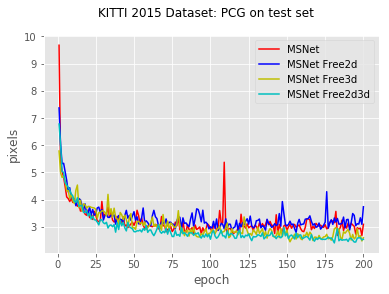

In [7]:
# figure 2
fig, ax = plt.subplots(1, 1)

for i, key in enumerate(paths_to_results_kitti2015.keys()):
    if paths_to_results_kitti2015[key] is not None:
        # load mean of each array 
        stats = torch.load(paths_to_results_kitti2015[key])['stats']
        if key in ['scalable_net', 'scalable_net_free_2d', 'scalable_net_free_3d']:
            arr = np.array(stats["val_full"]["pcg"]['0_after'])
        elif key == 'scalable_net_free_2d_3d':
            lis = stats["val_full"]["pcg"]['0_after']

        # plot line 
        if key == 'scalable_net':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax.plot(x , y, 'r-', label = key1[key])
        elif key == 'scalable_net_free_2d':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax.plot(x, y, 'b-', label = key1[key])
        elif key == 'scalable_net_free_3d':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax.plot(x, y, 'y-', label = key1[key])
        elif key == 'scalable_net_free_2d_3d':
            tmp = []
            for i in range(len(lis)):
                tmp.append(np.mean(lis[i]))
            ax.plot(np.arange(1, len(tmp) + 1), tmp, 'c-', label = key1[key])
        
fig.suptitle("KITTI 2015 Dataset: PCG on test set")
ax.set_ylabel("pixels")
ax.set_xlabel("epoch")
ax.legend()

fig.savefig(dir_to_save + 'pcg_test_set_scalable_vs_scalable_free_kitti2015.png')

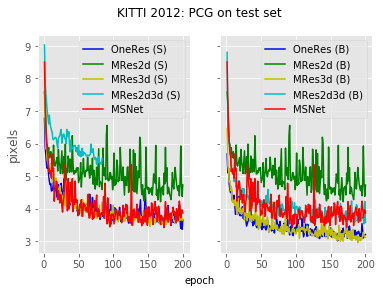

In [10]:
# figure 1
fig, ax = plt.subplots(1, 2, sharey='row')

def compute_mean_per_epoch(lis):
    mae = []
    for epoch in lis:
        mae.append(np.mean(epoch))
    return np.array(mae)

for i, key in enumerate(paths_to_results_kitti2012.keys()):
    if paths_to_results_kitti2012[key] is not None:
        # load mean of each array 
        stats = torch.load(paths_to_results_kitti2012[key])['stats']
        if key in ['one_res_small', 'one_res_big', 'mres_2d_small']:
            arr = np.array(stats["val_full"]["pcg"])
        elif key in ['mres_2d_big']:
            arr = arr
        elif key in ['mres_3d_small', 'mres_3d_big', 'mres_2d_3d_small', 'mres_2d_3d_big']:
            arr = np.array(stats["val_full"]["pcg"]['_4'])
        elif key in ['scalable_net']:
            arr = np.array(stats["val_full"]["pcg"]['0_after'])

        # plot line
        if key == 'one_res_small':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x, y, 'b-', label = key1[key])
        elif key == 'one_res_big':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[1].plot(x, y, 'b-', label = key1[key])
        elif key == 'mres_2d_small':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x ,y, 'g-', label = key1[key])
        elif key == 'mres_2d_big':
            y = compute_mean_per_epoch(arr)
            x = np.arange(1, y.shape[0] + 1)
            ax[1].plot(x, y, 'g-', label = key1[key])
        elif key == 'mres_3d_small':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x, y, 'y-', label = key1[key])
        elif key == 'mres_3d_big':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[1].plot(x, y, 'y-', label = key1[key])
        elif key == 'mres_2d_3d_small':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x, y, 'c-', label = key1[key])
        elif key == 'mres_2d_3d_big':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[1].plot(x, y, 'c-', label = key1[key])    
        elif key == 'scalable_net':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x, y, 'r-', label = key1[key])
            ax[1].plot(x, y, 'r-', label = key1[key])
        
fig.suptitle("KITTI 2012: PCG on test set")
ax[0].set_ylabel("pixels")
fig.text(0.5, 0.02, 'epoch', ha='center')
ax[0].legend()
ax[1].legend()

fig.savefig(dir_to_save + 'pcg_test_set_scalable_vs_simple_nets_kitti2012.png')

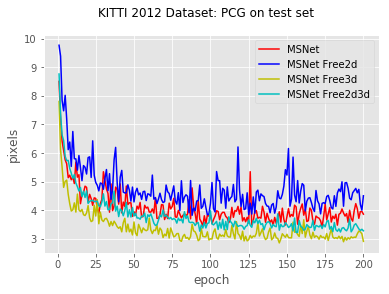

In [11]:
# figure 2
fig, ax = plt.subplots(1, 1)

for i, key in enumerate(paths_to_results_kitti2012.keys()):
    if paths_to_results_kitti2012[key] is not None:
        # load mean of each array 
        stats = torch.load(paths_to_results_kitti2012[key])['stats']
        if key in ['scalable_net', 'scalable_net_free_2d', 'scalable_net_free_3d']:
            arr = np.array(stats["val_full"]["pcg"]['0_after'])
        elif key == 'scalable_net_free_2d_3d':
            lis = stats["val_full"]["pcg"]['0_after']

        # plot line 
        if key == 'scalable_net':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax.plot(x , y, 'r-', label = key1[key])
        elif key == 'scalable_net_free_2d':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax.plot(x, y, 'b-', label = key1[key])
        elif key == 'scalable_net_free_3d':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax.plot(x, y, 'y-', label = key1[key])
        elif key == 'scalable_net_free_2d_3d':
            tmp = []
            for i in range(len(lis)):
                tmp.append(np.mean(lis[i]))
            ax.plot(np.arange(1, len(tmp) + 1), tmp, 'c-', label = key1[key])
        
fig.suptitle("KITTI 2012 Dataset: PCG on test set")
ax.set_ylabel("pixels")
ax.set_xlabel("epoch")
ax.legend()

fig.savefig(dir_to_save + 'pcg_test_set_scalable_vs_scalable_free_kitti2012.png')